In [1]:
# resnet50 处理图片，扣前景保留背景，存tensor格式
#获取数据集，GAN生成的z,G(z)得到图片，输入DNN_model，使用钩子函数定位最后一个卷积层的输出，插值得到和原来图片一样尺寸的mask,看一下长啥样
# CAM和gradCAM
# https://github.com/frgfm/torch-cam,一个方法库
import model_files as model_all
import torch
import time
import sys
import python_files.my_tools as my_tools
from torchcam.methods import SmoothGradCAMpp, GradCAMpp, SSCAM, CAM, GradCAM
from python_files.my_tools import get_zs_idw_not_class, get_foreground_by_cam

data = {
    "model_id": "M1",
    "model_name": "ResNet20",
    "dataset_type": "CIFAR10",
}
# data={
#     "model_id":"M2",
#     "model_name":"AlexNet",
#     "dataset_type":"CIFAR10",
#
# }
device_id = 0
device = torch.device("cuda:" + str(device_id))
model_id = data["model_id"]
model_name = data["model_name"]
print("model_id: ", model_id)
print("model_name: ", model_name)

#申明使用的是全局

dataset_type = data["dataset_type"]

# # CIFAR10生成模型
#
# checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"  #kjl测试#############
# global G
# print("数据类型为：", dataset_type)
# G = model_all.get_generative_model("CIFAR10").to(device)
# G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
# G.eval()
#
# # 提前加载预处理的数据（降维后的2维坐标和对应的高维向量）
# # tree_2D_path="./static/data/CIFAR10/2D_kdTree/2D_kdTree_200000.pt"
# # data_z_path="./static/data/CIFAR10/latent_z/BigGAN_208z_200000.pt"
#
# # tree_2D = torch.load(tree_2D_path)
# # dict_zs = torch.load(data_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
#
#
# # kjl测试superviced-cnn-ae####################################start
# tree_2D_path = "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2023-08-30.pt"
# data_z_path = "./static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
# tree_2D = torch.load(tree_2D_path)
# dict_zs = torch.load(data_z_path, map_location="cpu")
# #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
#
# Global_rob_predictor_dict = {}
Global_DNN_model = model_all.get_DNN_model(dataset_type, model_name)
#
# print("准备分类模型。。。")
Global_DNN_model.load_state_dict(torch.load("./model_files/" + dataset_type + "/checkpoints/classify_model/" + model_name + ".pt", map_location=device))

# Global_DNN_model = torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet20.pt", map_location=device)
Global_DNN_model.eval()
Global_DNN_model.to(device)




# print("DNN模型准备完毕，准备鲁棒性预测模型。。。")
#
# Global_rob_predictor_dict[model_id] = model_all.get_rob_predictor(dataset_type, model_name)
# Global_rob_predictor_dict[model_id].load_state_dict((torch.load(
#     "./model_files/" + dataset_type + "/checkpoints/rob_predictor/kjl_rob_predictor_" + model_name + ".pt",
#     map_location=device)))  #自动驾驶使用的8度鲁棒性
# Global_rob_predictor_dict[model_id].eval()
# Global_rob_predictor_dict[model_id].to(device)
# Rob_predictor = Global_rob_predictor_dict[model_id]

# DNN_model = Global_DNN_model_dict["M2"]
print("准备CAM对象。。。")
# 初始化 SmoothGradCAMpp 对象
DNN_model = Global_DNN_model
# 原始CAM是最快的，但是不适用于卷积后边接了多个fc的，也就是CAM只适用于MobileNet，ResNet系列，不适用AlexNet和VGG系列
# CAMmethod = CAM(DNN_model)

CAMmethod = CAM(DNN_model)
# CAMmethod = SmoothGradCAMpp(DNN_model)
print("CAM准备完毕。。。")



model_id:  M1
model_name:  ResNet20
准备CAM对象。。。


CAM准备完毕。。。


In [3]:
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import normalize, resize, to_pil_image

import torch
from PIL import Image
from matplotlib import pyplot as plt
# 创建一个空列表，用于存储每张图像的 masked_random_image_tensor
masked_tensors = []
# 图片处理
for i in range(50000):
    # 取图片
    random_image_filename = './static/data/' + dataset_type + f'/pic/origin_50k_png/pic_{i}.png'
    random_image = Image.open(random_image_filename)
    random_image_tensor = TF.to_tensor(random_image).unsqueeze(0).to(device)
    # 因为是从图片直接读取的，要跟image范围匹配，这样后边进行+1/2的操作不会颜色变浅
    random_image_tensor = random_image_tensor*2-1

    # 分类
    layers = DNN_model(random_image_tensor)  # 分类模型分类图片
    # CAMlayer = activation['layer3']
    max_value, label = torch.max(layers, dim=1)
    max_pro_id = layers.squeeze(0).argmax().item()
    # print(max_pro_id)
    # 解释图像并获取 CAM
    cams = CAMmethod(max_pro_id, layers)
    # 展开成32*32
    # print(cams)
    cams = torch.nn.functional.interpolate(cams[0].unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)


    # 每张图固定比例取前景
    # 将 CAM 张量展平为一维数组
    flat_cams = cams.view(-1)
    # 对展平后的数组进行排序
    sorted_cams, indices = torch.sort(flat_cams, descending=True)
    # 计算阈值索引
    threshold_index = int(len(sorted_cams) * 0.3)
    # 设置阈值
    threshold = sorted_cams[threshold_index]
    binary_cams = (cams >= threshold).to(dtype=torch.float32)

    # 在 binary_cams 上添加额外的维度以匹配 imgs 的通道数，并复制到三个通道
    expanded_binary_cams = binary_cams.repeat(1, 3, 1, 1)

    # 得到扣掉前景的背景图
    masked_random_image_tensor = random_image_tensor * (1 - expanded_binary_cams)
     # 将 masked_random_image_tensor 添加到列表中
    masked_tensors.append(masked_random_image_tensor)
    # if i%1000 == 0 :
    #     print(i)


# 将列表转换为 PyTorch tensor
masked_tensors_tensor = torch.stack(masked_tensors).squeeze(1)
print(masked_tensors_tensor.shape)
# 保存 tensor 到 .pt 文件
torch.save(masked_tensors_tensor, './static/data/' + dataset_type + f'/background/background_remove_fore.pt')





torch.Size([50000, 3, 32, 32])


torch.Size([1, 3, 32, 32])


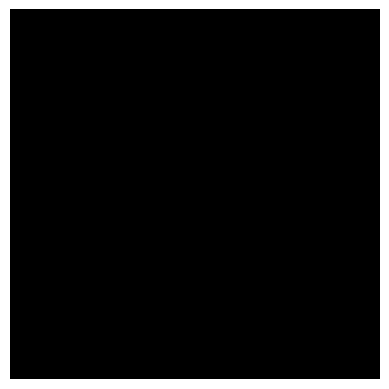

In [4]:
from matplotlib import pyplot as plt
import torch
# 读取 .pt 文件
dataset_type = 'CIFAR10'
loaded_tensor = torch.load('./static/data/' + dataset_type + f'/background/background_remove_fore.pt')

# 假设你想要取出第一个 tensor
first_tensor = loaded_tensor[1]
# 使用 unsqueeze() 方法在第一个维度上添加一个维度
reshaped_tensor = first_tensor.unsqueeze(0)

# 打印调整后的 tensor 形状
print(reshaped_tensor.shape)  # 应该是 [1, 3, 32, 32]

image_array = reshaped_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# 绘制图像
plt.imshow(image_array)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [3]:
# import torch
# data_z_path = "./static/data/CIFAR10/labels/BigGAN_random_png_208z_50000_2023-08-30_labels.pt"
# dict_zs = torch.load(data_z_path, map_location="cpu")  # 因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
# print(dict_zs.shape)

torch.Size([50000])


In [17]:
import torch

# 创建一个全零的 32x32 的 tensor
mask = torch.zeros(32, 32)

# 将一个 8x8 的方块设置为 1
mask[0:8, 0:8] = 1

# 打印掩码
print(mask)
mask_tensor = mask.unsqueeze(0).unsqueeze(0)
expanded_mask_tensor = mask.repeat(1, 3, 1, 1)
print(expanded_mask_tensor.shape)

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([1, 3, 32, 32])
